#### **Declare path to project directory**

In [1]:
# path_to_directory = "/home/antonio/ist/data-science/proj/forecasting"
path_to_directory = "/home/morais/data_science_project"

## **Missing Values Imputation**

Dataset nr records=58 nr variables=12


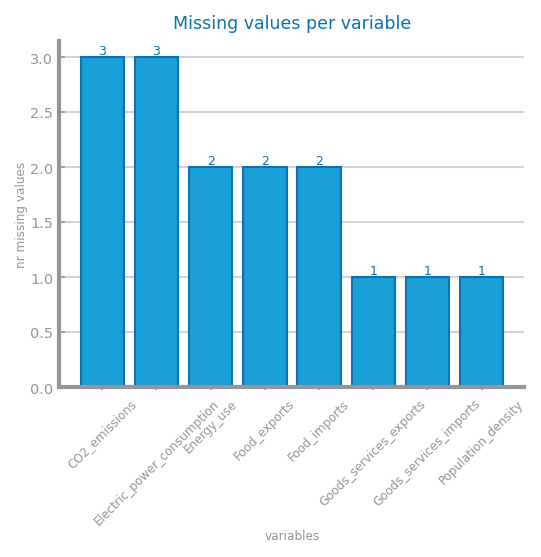

In [2]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, show, savefig
from dslabs_functions import plot_bar_chart

filename = f"{path_to_directory}/datasets/forecast_gdp_europe.csv"

data: DataFrame = read_csv(filepath_or_buffer=filename, na_values="", index_col=None, sep=',', decimal='.')
print(f"Dataset nr records={data.shape[0]}", f"nr variables={data.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in data:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)

savefig(f"{path_to_directory}/images/Set 2 - Nr missing values.png", bbox_inches='tight')
show()

#### Evaluation - Linear Regression Model

(58, 11)
(46,) (12,)
R2 = -18.747849691393814


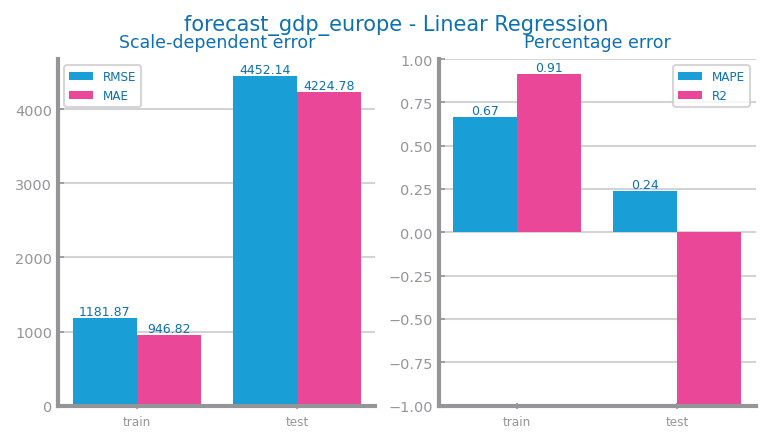

In [3]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, FORECAST_MEASURES, HEIGHT, set_chart_labels, FONT_TEXT
from matplotlib.axes import Axes
from numpy import ndarray, arange
from math import sqrt
from matplotlib.container import BarContainer

def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size, -1]
    test: Series = df_cp.iloc[trn_size:, -1]
    return train, test

def plot_multibar_chart(
    group_labels: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes | list[Axes]:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    bar_labels: list = list(yvalues.keys())

    # This is the location for each bar
    index: ndarray = arange(len(group_labels))
    bar_width: float = 0.8 / len(bar_labels)
    ax.set_xticks(index + bar_width / 2, labels=group_labels)

    for i in range(len(bar_labels)):
        bar_yvalues = yvalues[bar_labels[i]]
        values: BarContainer = ax.bar(
            index + i * bar_width,
            bar_yvalues,
            width=bar_width,
            label=bar_labels[i],
        )
        format = "%.2f" if percentage else "%.2f"  # Updated format for better precision
        ax.bar_label(values, fmt=format, fontproperties=FONT_TEXT)
        if any(y < 0 for y in bar_yvalues) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.legend(fontsize="xx-small")

    return ax

def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # Extract the R2 value for the test data
    r2_tst = FORECAST_MEASURES["R2"](tst, prd_tst)

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs, r2_tst

filename: str = f"{path_to_directory}/datasets/forecast_gdp_europe.csv"
file_tag: str = "forecast_gdp_europe"
target: str = "GDP"
timecol: str = "Year"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
print(data.shape)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.80)
print(train.shape, test.shape)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_original = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
print(f"R2 = {r2_original}")

<Axes: xlabel='Year', ylabel='GDP'>

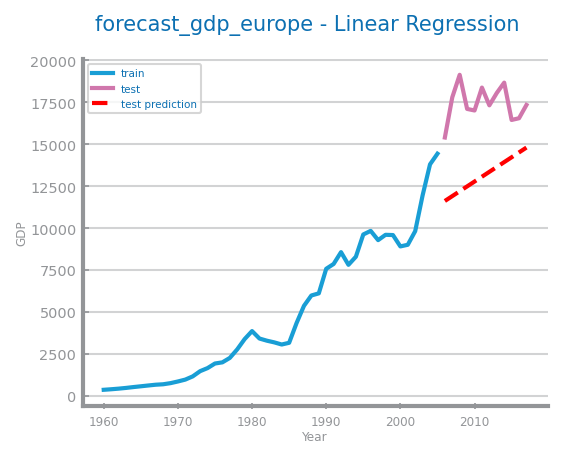

In [4]:
from dslabs_functions import PAST_COLOR, FUTURE_COLOR, PRED_FUTURE_COLOR

def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    # fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig, ax = subplots(1, 1, squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)

### **Dropping Missing Values**

In [5]:
print(data.shape)
df_drop: DataFrame = data.dropna(how="any", inplace=False)
print(df_drop.shape)
df_drop.to_csv(f"{path_to_directory}/datasets/{file_tag}_MVI_drop.csv", index=True)

(58, 11)
(53, 11)


#### Evaluation - Linear Regression Model

(53, 11)
(42,) (11,)


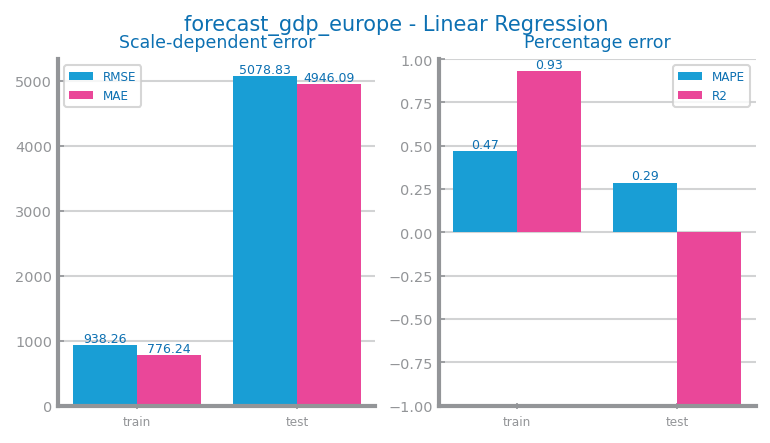

In [6]:
print(df_drop.shape)
series: Series = df_drop[target]
train, test = series_train_test_split(df_drop, trn_pct=0.80)
print(train.shape, test.shape)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(df_drop)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_drop = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after applying MVI (drop).png", bbox_inches='tight')

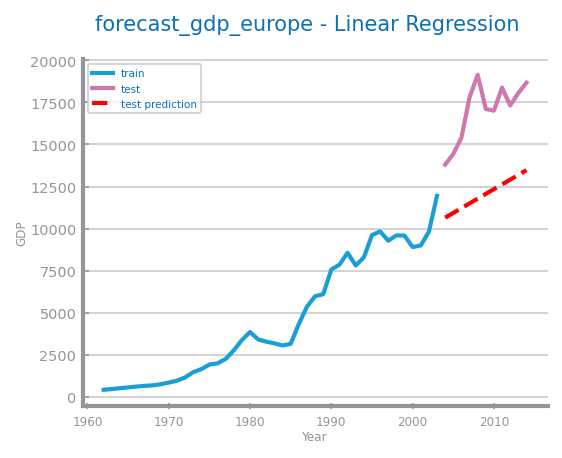

In [7]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after applying MVI (drop).png", bbox_inches='tight')

### **Filling missing values**
#### Frequent

In [8]:
from dslabs_functions import mvi_by_filling

df_fill_freq: DataFrame = mvi_by_filling(data, strategy="frequent")
# df_fill_freq.head(10)

##### Evaluation - Linear Regression Model

(58, 11)
(46,) (12,)


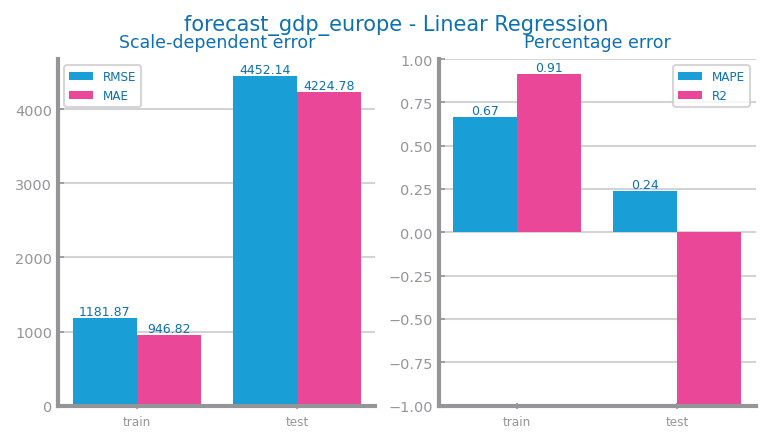

In [9]:
print(df_fill_freq.shape)
series: Series = df_fill_freq[target]
train, test = series_train_test_split(df_fill_freq, trn_pct=0.80)
print(train.shape, test.shape)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(df_fill_freq)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_fill_freq = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")

<Axes: xlabel='Year', ylabel='GDP'>

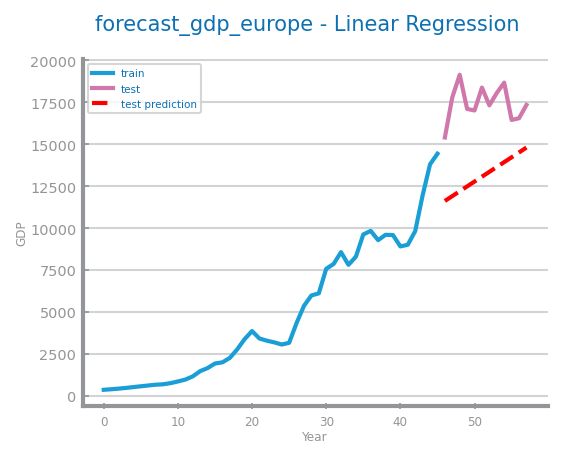

In [10]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)

#### Constant

In [11]:
from dslabs_functions import mvi_by_filling

df_fill_const: DataFrame = mvi_by_filling(data, strategy="constant")
# df_fill_freq.head(10)

##### Evaluation - Linear Regression Model

(58, 11)
(46,) (12,)


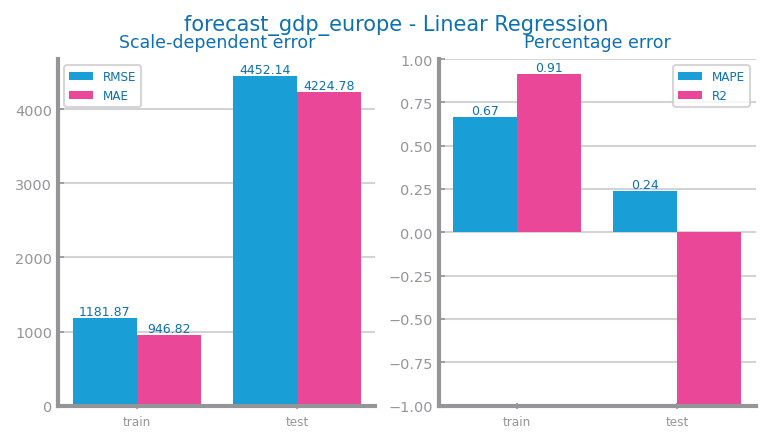

In [12]:
print(df_fill_const.shape)
series: Series = df_fill_const[target]
train, test = series_train_test_split(df_fill_const, trn_pct=0.80)
print(train.shape, test.shape)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(df_fill_const)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_fill_const = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")

<Axes: xlabel='Year', ylabel='GDP'>

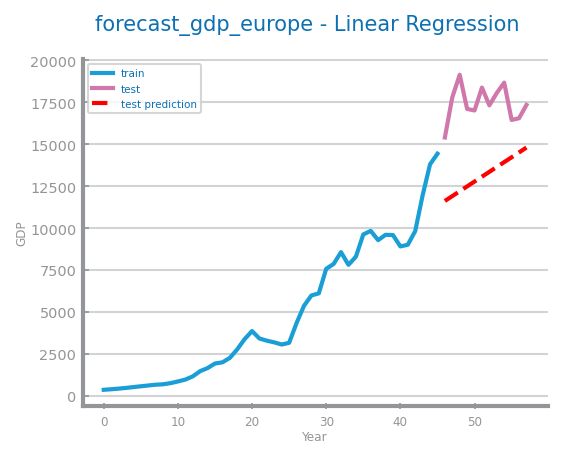

In [13]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)

#### KNN

In [14]:
from dslabs_functions import mvi_by_filling

df_fill_knn: DataFrame = mvi_by_filling(data, strategy="knn")
# df_fill_freq.head(10)

##### Evaluation - Linear Regression Model

(58, 11)
(46,) (12,)


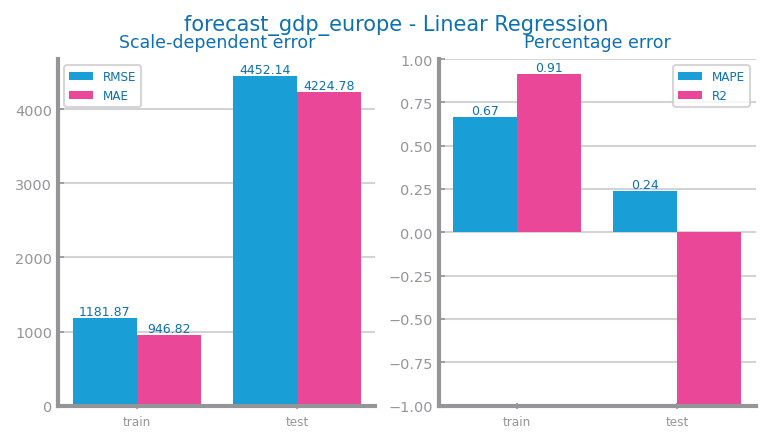

In [15]:
print(df_fill_knn.shape)
series: Series = df_fill_knn[target]
train, test = series_train_test_split(df_fill_knn, trn_pct=0.80)
print(train.shape, test.shape)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(df_fill_knn)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_fill_knn = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")

<Axes: xlabel='Year', ylabel='GDP'>

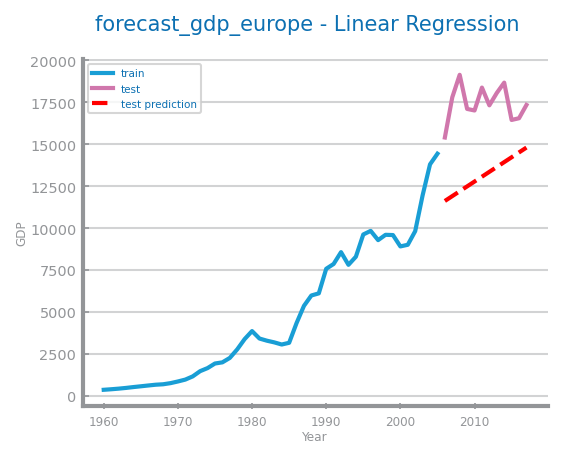

In [16]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)

### **Missing Values Imputation Evaluation**

In [17]:
# Define the R2 values
r2_values = {
    "original": r2_original,
    "drop": r2_drop,
    "fill freq": r2_fill_freq,
    "fill const": r2_fill_const,
    "fill knn": r2_fill_knn,
}

# Find the key with the maximum R2 value
highest_r2_label = max(r2_values, key=r2_values.get)
highest_r2_value = r2_values[highest_r2_label]

# Print the R2 values and the highest one
print(f"R2 values: {r2_values}")
print(f"Highest R2 is '{highest_r2_label}' with a value of {highest_r2_value}")

R2 values: {'original': -18.747849691393814, 'drop': -8.30348840324838, 'fill freq': -18.747849691393814, 'fill const': -18.747849691393814, 'fill knn': -18.747849691393814}
Highest R2 is 'drop' with a value of -8.30348840324838


In [18]:
data = df_drop
r2_previous = r2_drop
r2_previous_label = "drop"

# **Time Series Transformation**
## **Scaling**

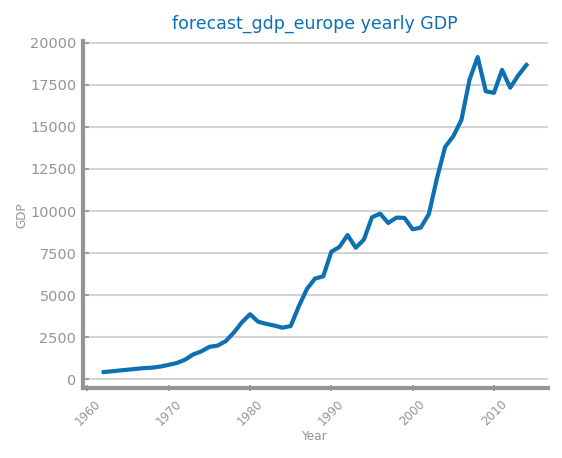

In [19]:
from sklearn.preprocessing import StandardScaler
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT


file_tag = "forecast_gdp_europe"
target = "GDP"
# filename = f'{path_to_directory}/datasets/forecast_gdp_europe.csv'
# data: DataFrame = read_csv(
#     filepath_or_buffer=filename,
#     index_col="Year",
#     sep=",",
#     decimal=".",
#     parse_dates=True,
#     infer_datetime_format=True,
# )

series: Series = data[target]

# figure(figsize=(3 * HEIGHT, HEIGHT / 2))
figure()
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} yearly {target}",
)
show()

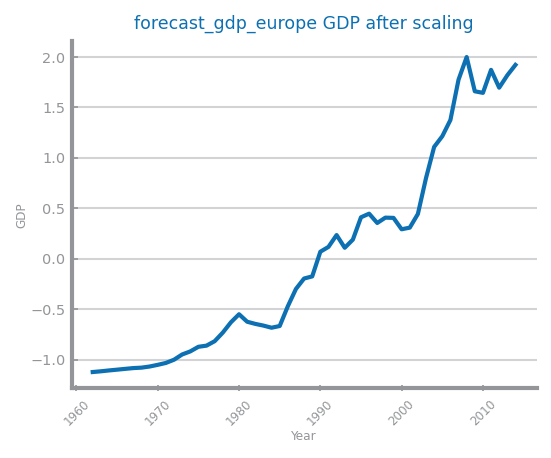

In [20]:
from matplotlib.pyplot import figure, show, savefig


def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

df_scaling: DataFrame = scale_all_dataframe(data)
df_scaling.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaling.csv", index=True)

ss_scaling: Series = df_scaling[target]
# figure(figsize=(3 * HEIGHT, HEIGHT / 2))
figure()
plot_line_chart(
    ss_scaling.index.to_list(),
    ss_scaling.to_list(),
    xlabel=ss_scaling.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)

# savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after scaling.png", bbox_inches='tight')
show()

### Evaluation - Linear Regression Model

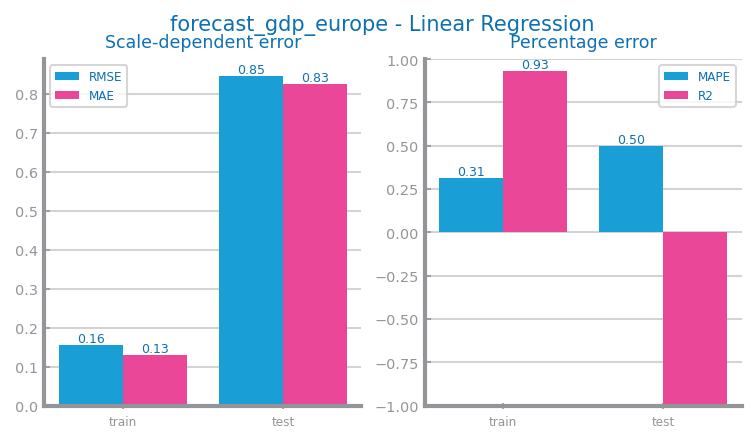

In [21]:
# filename: str = f"{path_to_directory}/datasets/forecast_gdp_europe.csv"
# file_tag: str = "forecast_gdp_europe"
# target: str = "GDP"
# timecol: str = "Year"

# data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
# series: Series = data[target]
train, test = series_train_test_split(df_scaling, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(df_scaling)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_scaling = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after scaling.png", bbox_inches='tight')

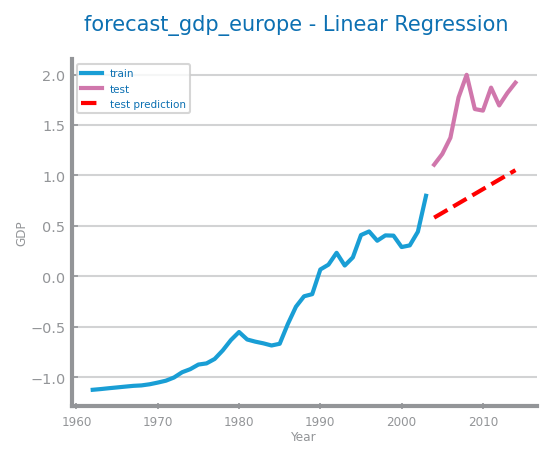

In [22]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after scaling.png", bbox_inches='tight')

### Scaling Evaluation

In [23]:
# Define the R2 values
r2_values = {
    f"{r2_previous_label}": r2_previous,
    "scaling": r2_scaling
}

# Find the key with the maximum R2 value
highest_r2_label = max(r2_values, key=r2_values.get)
highest_r2_value = r2_values[highest_r2_label]

# Print the R2 values and the highest one
print(f"R2 values: {r2_values}")
print(f"Highest R2 is '{highest_r2_label}' with a value of {highest_r2_value}")

# Assign variables based on the highest R2 label
if highest_r2_label == "scaling":
    data = df_scaling
    r2_previous = r2_scaling
    r2_previous_label = highest_r2_label

R2 values: {'drop': -8.30348840324838, 'scaling': -8.303488403248377}
Highest R2 is 'scaling' with a value of -8.303488403248377


## **Aggregation**
### Multivariate Time Series
### 1st & 2nd Granularity

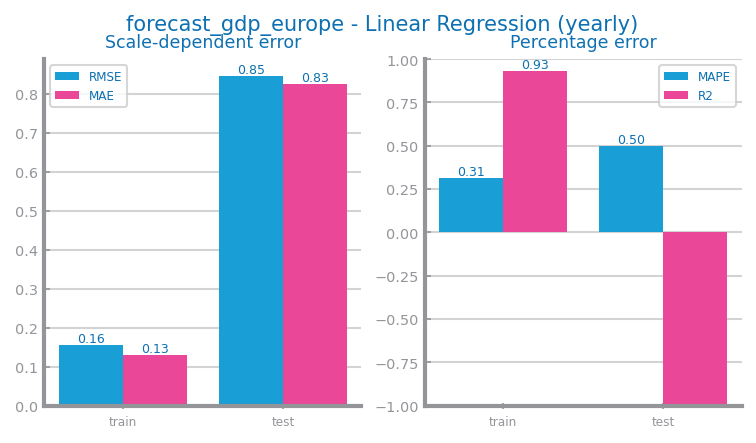

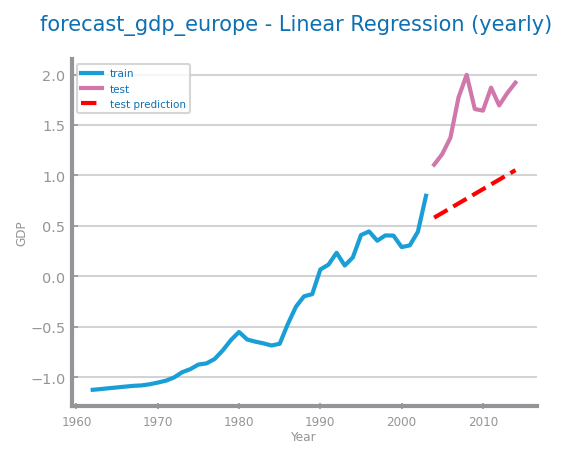

In [24]:
_, r2_scaling = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (yearly)")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after aggregation (yearly).png", bbox_inches='tight')

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression (yearly)",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after aggregation (yearly).png", bbox_inches='tight')

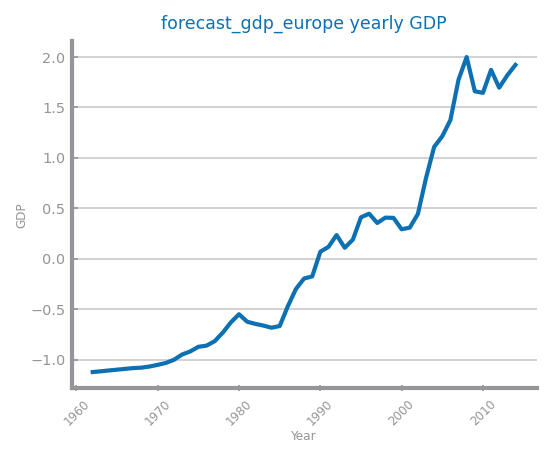

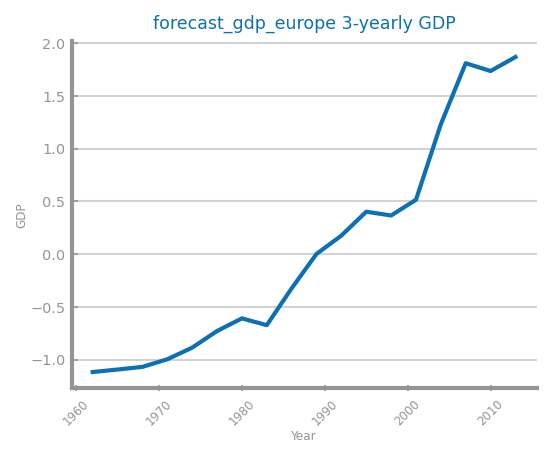

In [25]:
from dslabs_functions import Figure
from pandas import Index, Period, Series, DataFrame
import pandas as pd


def plot_ts_multivariate_chart(data: DataFrame, title: str) -> list[Axes]:
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(data.shape[1], 1, figsize=(3, HEIGHT / 2 * data.shape[1]))
    fig.suptitle(title)

    for i in range(data.shape[1]):
        col: str = data.columns[i]
        auxi_ax: Axes = plot_line_chart(
            data[col].index.to_list(),
            data[col].to_list(),
            ax=axs[i],
            xlabel=data.index.name,
            ylabel=col,
        )
        auxi_ax.tick_params(axis="x", labelbottom="off")
    return axs

def ts_aggregation_by(
    data: Series | DataFrame,
    gran_level: str = "D",
    agg_func: str = "mean",
    custom_years: int = None  # New argument for multi-year aggregation
) -> Series | DataFrame:
    df: Series | DataFrame = data.copy()
    
    if custom_years:  
        year_index = df.index.year
        custom_period = (year_index // custom_years) * custom_years
        df.index = pd.to_datetime(custom_period, format="%Y")
        # df.index.name = f"{custom_years}_year_period"
    else:
        # Default time granularity
        index: Index[Period] = df.index.to_period(gran_level)
        df.index = index.to_timestamp()
    
    # Group by the new index and aggregate
    df = df.groupby(df.index, dropna=True, sort=True).agg(agg_func)
    
    return df

# file_tag = "Consumption"
# target = "Appliances"
# data: DataFrame = read_csv(
#     "data/time_series/appliances.csv",
#     index_col="date",
#     sep=",",
#     decimal=".",
#     parse_dates=True,
#     infer_datetime_format=True,
# )

series: Series = data[target]
figure()
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} yearly {target}",
)
show()

agg_df_3_year: DataFrame = ts_aggregation_by(data, custom_years=3, agg_func="mean")
series_3: Series = agg_df_3_year[target]

figure()
plot_line_chart(
    series_3.index.to_list(),
    series_3.to_list(),
    xlabel=series_3.index.name,
    ylabel=target,
    title=f"{file_tag} 3-yearly {target}",
)
show()

### Evaluation - Linear Regression Model

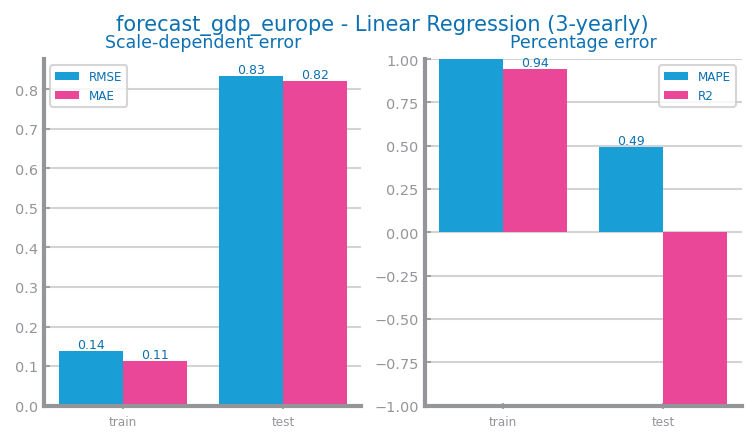

In [26]:
train, test = series_train_test_split(agg_df_3_year, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(agg_df_3_year)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_agg_3 = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (3-yearly)")

<Axes: xlabel='Year', ylabel='GDP'>

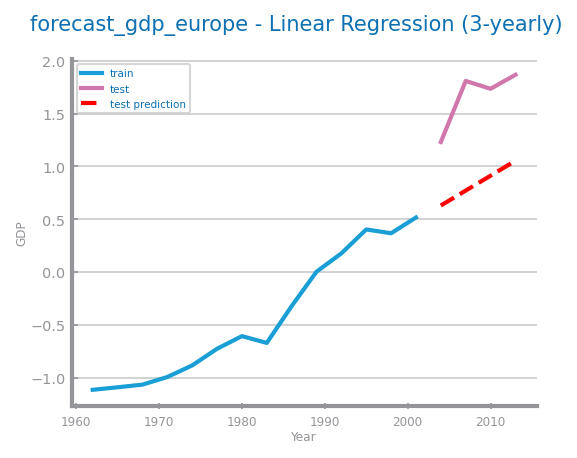

In [27]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression (3-yearly)",
    xlabel=timecol,
    ylabel=target,
)

### 3rd Granularity

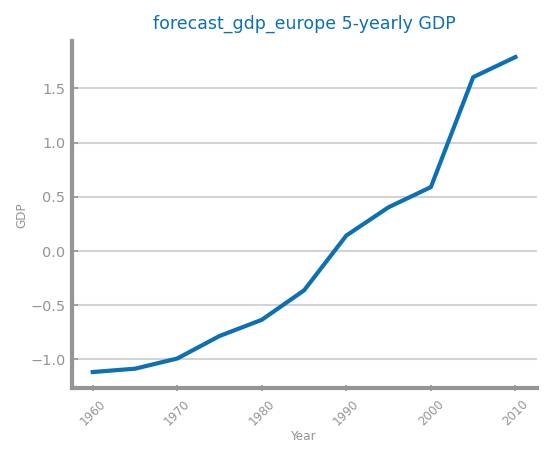

In [28]:
agg_df_5_year: DataFrame = ts_aggregation_by(data, custom_years=5, agg_func="mean")
series_5: Series = agg_df_5_year[target]

figure()
plot_line_chart(
    series_5.index.to_list(),
    series_5.to_list(),
    xlabel=series_5.index.name,
    ylabel=target,
    title=f"{file_tag} 5-yearly {target}",
)
show()

### Evaluation - Linear Regression Model

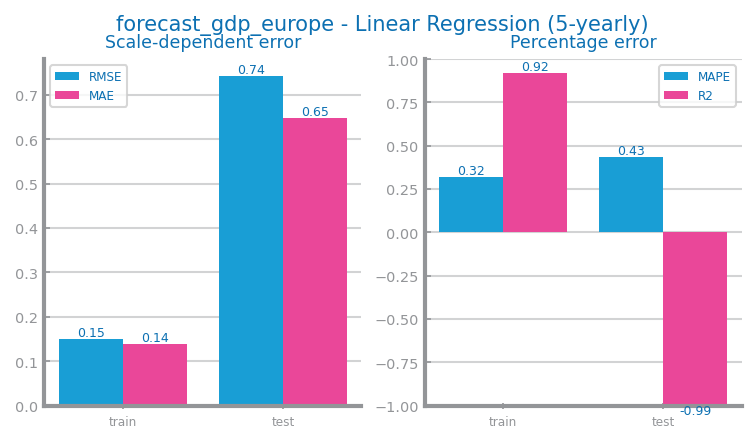

In [29]:
train, test = series_train_test_split(agg_df_5_year, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(agg_df_5_year)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_agg_5 = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (5-yearly)")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after aggregation (5-yearly).png", bbox_inches='tight')

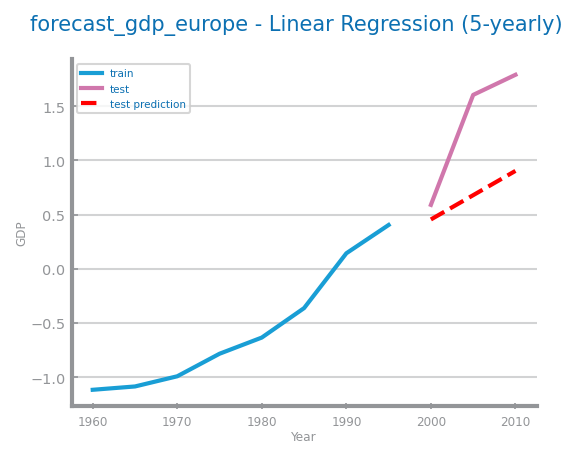

In [30]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression (5-yearly)",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after aggregation (5-yearly).png", bbox_inches='tight')

### 4th Granularity

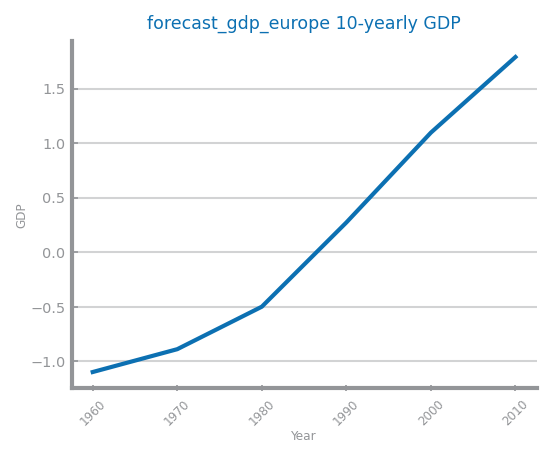

In [31]:
agg_df_10_year: DataFrame = ts_aggregation_by(data, custom_years=10, agg_func="mean")
series_10: Series = agg_df_10_year[target]

figure()
plot_line_chart(
    series_10.index.to_list(),
    series_10.to_list(),
    xlabel=series_10.index.name,
    ylabel=target,
    title=f"{file_tag} 10-yearly {target}",
)
show()

### Evaluation - Linear Regression Model

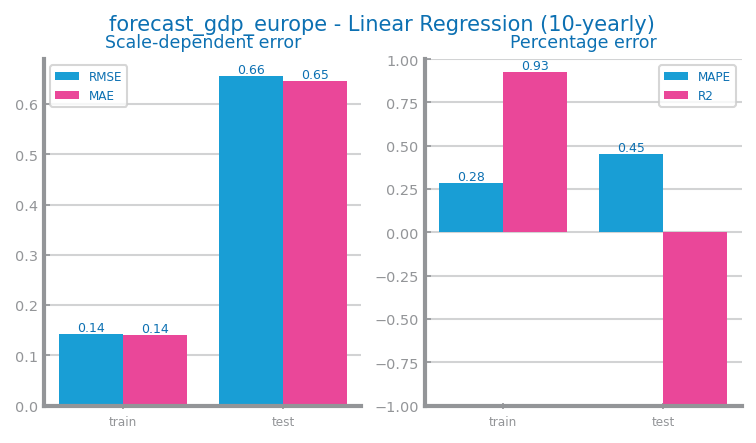

In [32]:
train, test = series_train_test_split(agg_df_10_year, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(agg_df_10_year)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

_, r2_agg_10 = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (10-yearly)")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after aggregation (10-yearly).png", bbox_inches='tight')

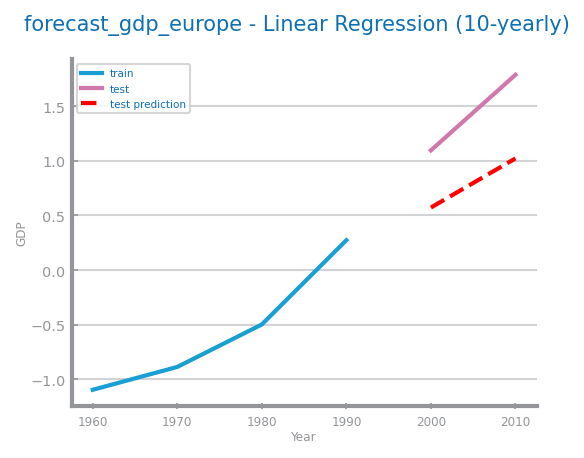

In [33]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression (10-yearly)",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after aggregation (10-yearly).png", bbox_inches='tight')

### Aggregation Evaluation

In [34]:
# Define the R2 values
r2_values = {
    f"{r2_previous_label}": r2_previous,
    "3 years": r2_agg_3,
    "5 years": r2_agg_5,
    "10 years": r2_agg_10,
}

# Find the key with the maximum R2 value
highest_r2_label = max(r2_values, key=r2_values.get)
highest_r2_value = r2_values[highest_r2_label]

# Print the R2 values and the highest one
print(f"R2 values: {r2_values}")
print(f"Highest R2 is '{highest_r2_label}' with a value of {highest_r2_value}")

# Assign variables based on the highest R2 label
if highest_r2_label == "3 years":
    data = agg_df_3_year
    r2_previous = r2_agg_3
    r2_previous_label = highest_r2_label
elif highest_r2_label == "5 years":
    data = agg_df_5_year
    r2_previous = r2_agg_5
    r2_previous_label = highest_r2_label
elif highest_r2_label == "10 years":
    data = agg_df_10_year
    r2_previous = r2_agg_10
    r2_previous_label = highest_r2_label

R2 values: {'scaling': -8.303488403248377, '3 years': -9.897973729543434, '5 years': -0.9889780223492923, '10 years': -2.593444730900269}
Highest R2 is '5 years' with a value of -0.9889780223492923


## **Smoothing**
Smoothing must only be applied to training data

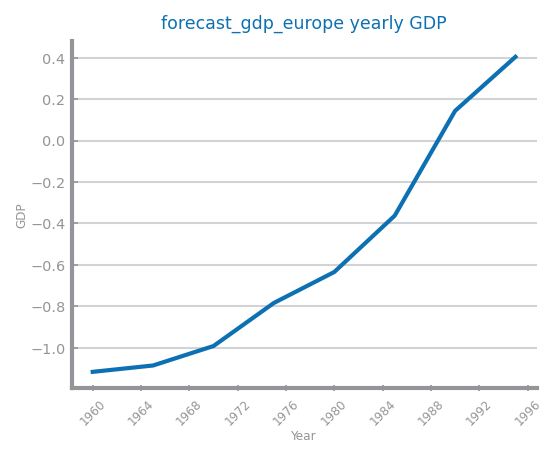

In [35]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT


train, test = series_train_test_split(data, trn_pct=0.80)

series: Series = train

# figure(figsize=(3 * HEIGHT, HEIGHT / 2))
figure()
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} yearly {target}",
)
show()

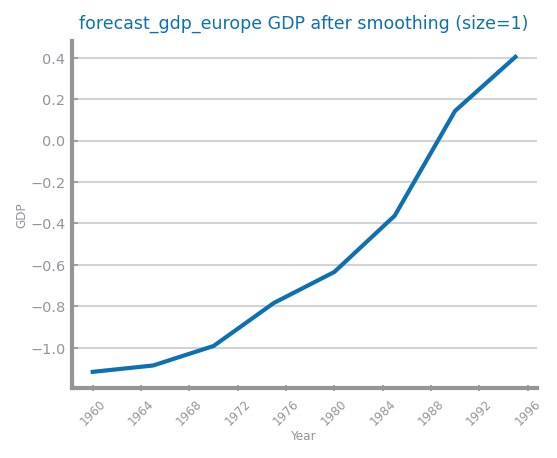

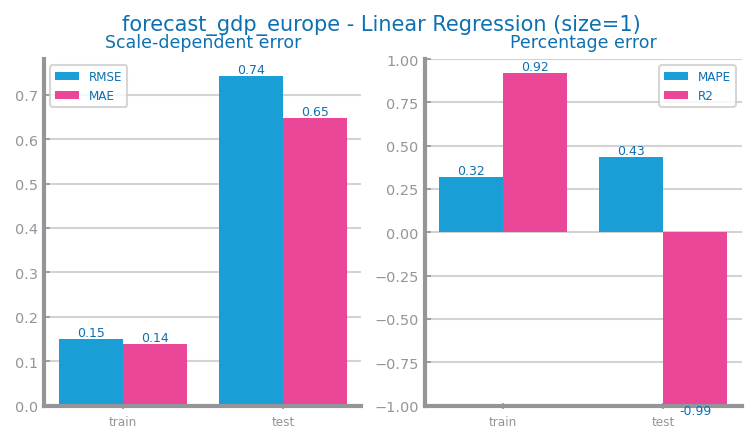

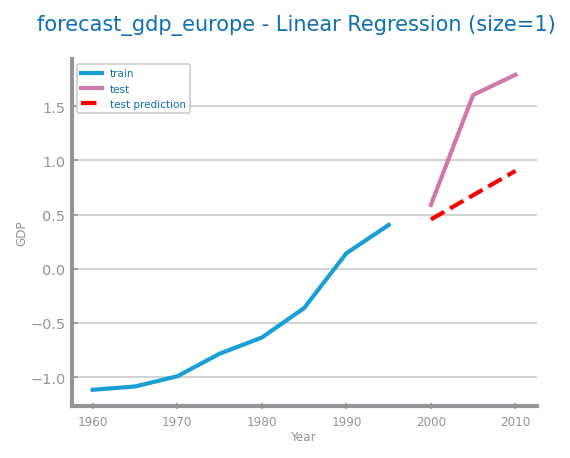

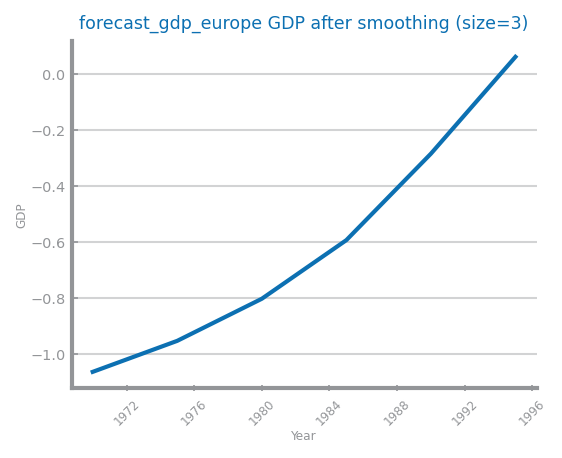

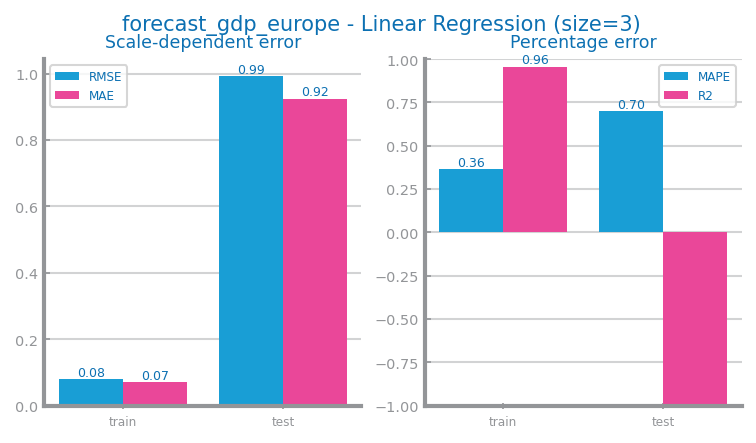

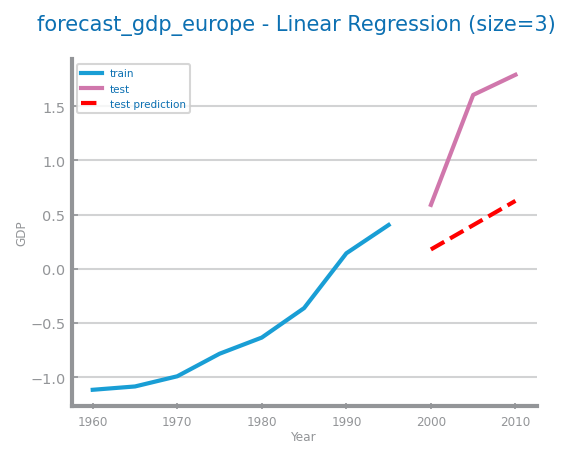

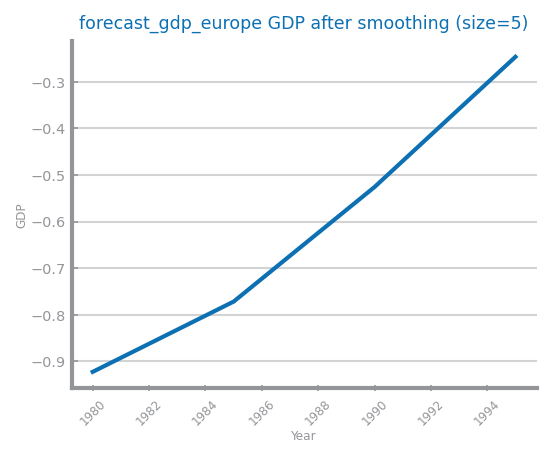

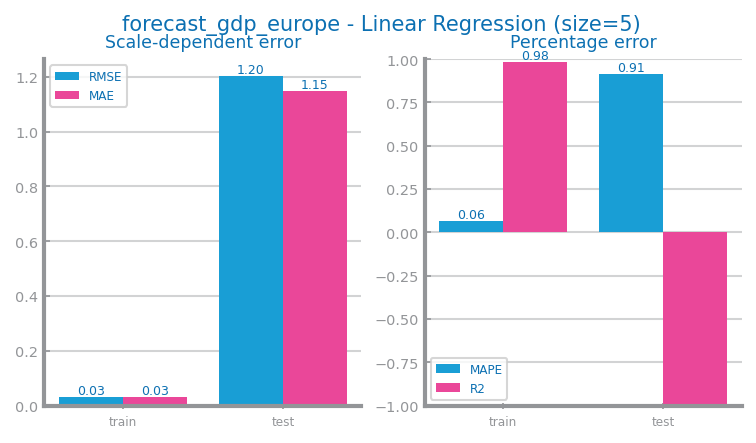

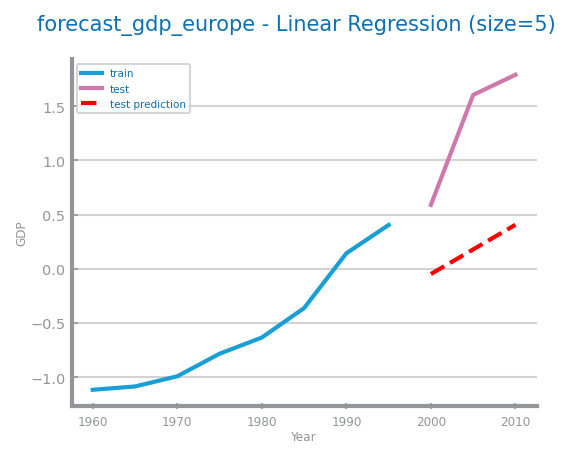

In [36]:
from numpy import isnan

evaluation_results = {}  # Dictionary to store evaluation results for each size
evaluation_results[0] = r2_previous
sizes: list[int] = [1, 3, 5]

for size in sizes:
    # Smooth the series using a rolling window
    ss_smooth: Series = series.rolling(window=size).mean()

    # Plot smoothed data
    figure()
    plot_line_chart(
        ss_smooth.index.to_list(),
        ss_smooth.to_list(),
        xlabel=ss_smooth.index.name,
        ylabel=target,
        title=f"{file_tag} {target} after smoothing (size={size})",
    )

    # Prepare training and testing data
    trnX = arange(len(ss_smooth)).reshape(-1, 1)
    trnY = ss_smooth.to_numpy()
    tstX = arange(len(ss_smooth), len(data)).reshape(-1, 1)
    tstY = test.to_numpy()

    # Exclude NaN values from the training data
    valid_indices = ~isnan(trnY)  # Boolean mask for valid (non-NaN) entries
    trnX_valid = trnX[valid_indices]
    trnY_valid = trnY[valid_indices]

    # Train the model on valid data
    model = LinearRegression()
    model.fit(trnX_valid, trnY_valid)

    # Predict on training and testing data
    prd_trn_values = model.predict(trnX_valid)
    prd_trn: Series = Series(prd_trn_values, index=ss_smooth.index[valid_indices])

    prd_tst_values = model.predict(tstX)
    prd_tst: Series = Series(prd_tst_values, index=test.index)

    # Align the indices of the smoothed series to avoid mismatches
    ss_smooth_valid = ss_smooth.dropna()

    # Plot forecasting evaluation
    _, evaluation_results[size] = plot_forecasting_eval(ss_smooth_valid, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (size={size})")
    savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after smoothing (size={size}).png", bbox_inches='tight')

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression (size={size})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after smoothing (size={size}).png", bbox_inches='tight')
    show()


### Smoothing Evaluation

In [37]:
best_size = max(evaluation_results, key=lambda size: evaluation_results[size])
best_value = evaluation_results[best_size]

# Print all evaluation results and the best one
print(f"Evaluation results: {evaluation_results}")
print(f"The best result is for size '{best_size}' with a value of {best_value}")

Evaluation results: {0: -0.9889780223492923, 1: -0.9889780223492923, 3: -2.553461292085483, 5: -4.2164474823855205}
The best result is for size '0' with a value of -0.9889780223492923


## **Differentiation**

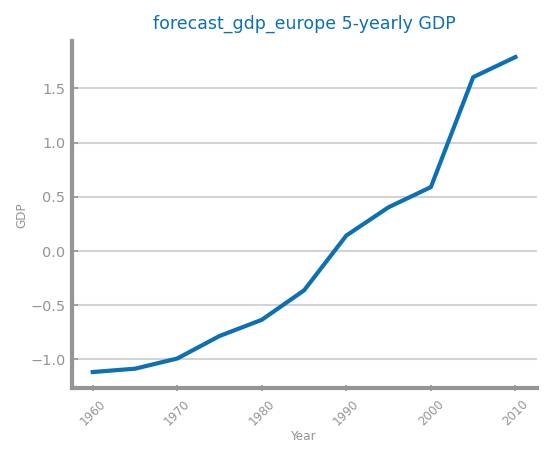

In [38]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

series: Series = data[target]

figure()
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} 5-yearly {target}",
)
show()

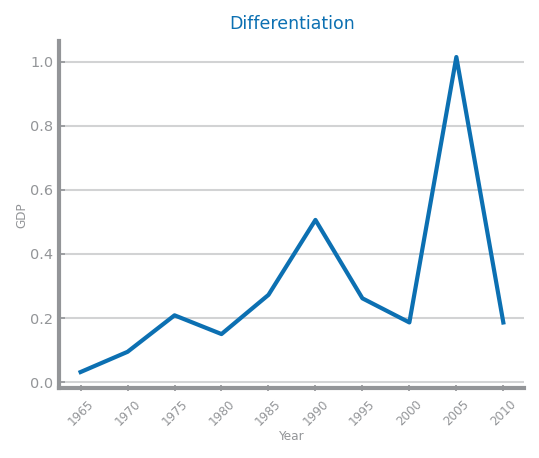

In [39]:
from dslabs_functions import plot_line_chart

ss_diff: Series = series.diff()
figure()
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
show()

### Evaluation - Linear Regression Model

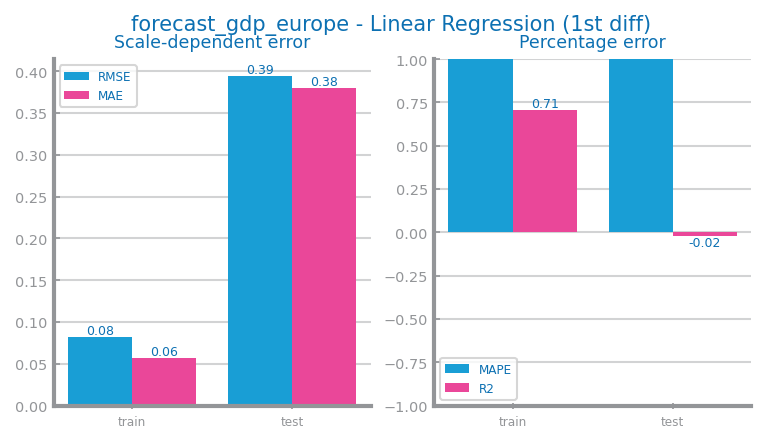

In [40]:
def series_train_test_split2(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size]
    test: Series = df_cp.iloc[trn_size:]
    return train, test

# Split the data
train, test = series_train_test_split2(ss_diff.fillna(0), trn_pct=0.80)  # Fill NaNs with 0 in `ss_diff`

# Prepare train and test inputs
trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(ss_diff)).reshape(-1, 1)
tstY = test.to_numpy()

# Train the model
model = LinearRegression()
model.fit(trnX, trnY)

# Make predictions
prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

# Evaluate and plot
_, r2_diff = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (1st diff)")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after differentiation (1st).png", bbox_inches='tight')

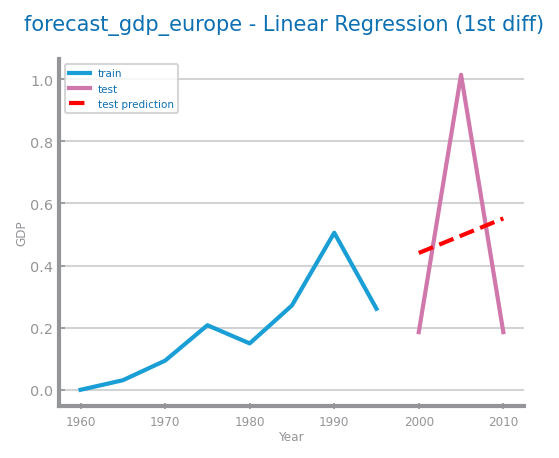

In [41]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression (1st diff)",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after differentiation (1st).png", bbox_inches='tight')

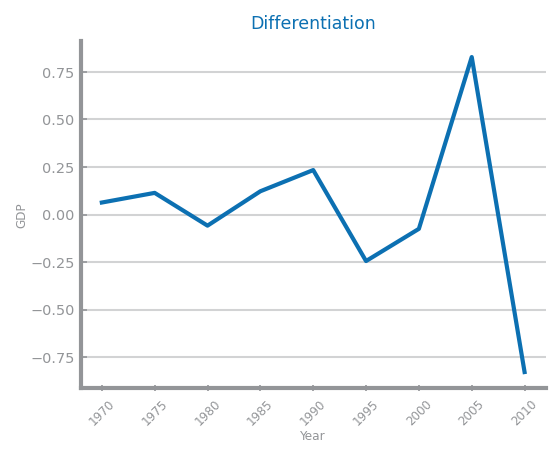

In [42]:
from dslabs_functions import plot_line_chart

ss_diff2: Series = ss_diff.diff()
figure()
plot_line_chart(
    ss_diff2.index.to_list(),
    ss_diff2.to_list(),
    title="Differentiation",
    xlabel=ss_diff.index.name,
    ylabel=target,
)
show()

### Evaluation - Linear Regression Model

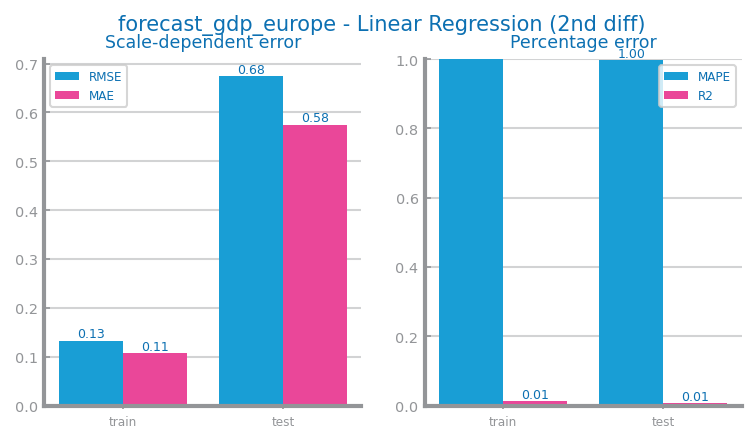

In [43]:
# Split the data
train, test = series_train_test_split2(ss_diff2.fillna(0), trn_pct=0.80)  # Fill NaNs with 0 in `ss_diff`

# Prepare train and test inputs
trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(ss_diff2)).reshape(-1, 1)
tstY = test.to_numpy()

# Train the model
model = LinearRegression()
model.fit(trnX, trnY)

# Make predictions
prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

# Evaluate and plot
_, r2_diff2 = plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression (2nd diff)")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results after differentiation (2nd).png", bbox_inches='tight')

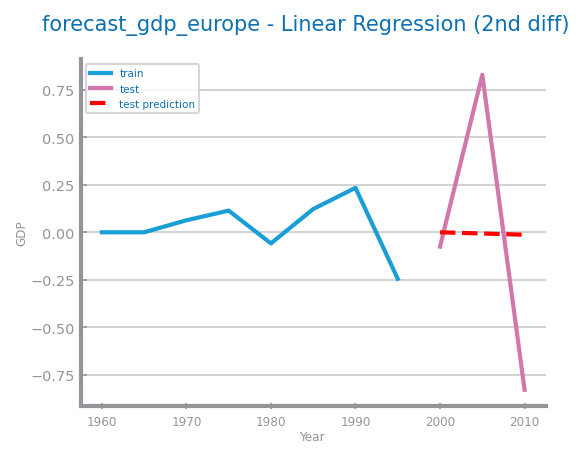

In [44]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression (2nd diff)",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots after differentiation (2nd).png", bbox_inches='tight')

### Differentiation Evaluation

In [45]:
# Define the R2 values
r2_values = {
    f"{r2_previous_label}": r2_previous,
    "1st diff": r2_diff,
    "2nd diff": r2_diff2
}

# Find the key with the maximum R2 value
highest_r2_label = max(r2_values, key=r2_values.get)
highest_r2_value = r2_values[highest_r2_label]

# Print the R2 values and the highest one
print(f"R2 values: {r2_values}")
print(f"Highest R2 is '{highest_r2_label}' with a value of {highest_r2_value}")

R2 values: {'5 years': -0.9889780223492923, '1st diff': -0.021287873733578655, '2nd diff': 0.006193270266576567}
Highest R2 is '2nd diff' with a value of 0.006193270266576567
